### 1D-CNN Demo

In [1]:
import os
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

from src.one_d_cnn import *
from src.one_d_transformer import *
from src.mlp import *
from src.one_d_attention import *

import sklearn
import pickle

In [2]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

In [3]:
random.seed(1234)
torch.manual_seed(1234)

#### Model Flag

In [4]:
# MODEL_FLAG = 'cnn'
# MODEL_FLAG = 'transformer'
# MODEL_FLAG = 'mlp'
MODEL_FLAG = 'attention'

#### Attention

In [5]:
if MODEL_FLAG == 'attention':
    model = OneAttention()
    model

##### Test Model

In [6]:
# batch, seq, feature
src = torch.rand(16, 1, 95)

In [7]:
if MODEL_FLAG == 'attention':
    model = model.to(device)
    src = src.to(device)
    out = model(src)
    print(out.shape)

torch.Size([16, 1])


#### 1D-Transformer

In [5]:
if MODEL_FLAG == 'transformer':
    model = OneDTransformer(
        n_classes=256, 
        n_label=1,
        n_length=95,
        n_channel=1,
        vocab_size=100, 
        num_embed=64,
        embed_size=256,
        nhead=4, 
        dim_feedforward=512, 
        dropout=0.25,
        activation='relu',
        verbose=True
    )

    model

##### Test Model

In [5]:
# batch, seq, feature
src = torch.rand(16, 1, 95)

In [7]:
if MODEL_FLAG == 'transformer':
    model = model.to(device)
    src = src.to(device)
    out = model(src)

#### 1D-CNN

In [8]:
# batch, seq, feature
src = torch.rand(16, 1, 95)

In [9]:
if MODEL_FLAG == 'cnn':
    model = OneDCNN()
    src = src.to(device)
    out = model(src)

In [10]:
out.shape

torch.Size([16, 1])

#### MLP

In [11]:
if MODEL_FLAG == 'mlp':
    model = OurMLP(num_classes=1, in_channels=95)
    model

##### Test Model

In [12]:
if MODEL_FLAG == 'cnn':
    test_x = torch.rand(1, 1, 95)
    test_y = model(test_x)
    print(test_y.shape)
    test_y

torch.Size([1, 1])


In [13]:
if MODEL_FLAG == 'mlp':
    test_x = torch.rand(1, 1, 95)
    test_y = model(test_x)
    print(test_y.shape)
    test_y

### Dataset

In [8]:
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from src.custom_dataset import RadiomicDataset
from sklearn.model_selection import KFold

In [10]:
root_dir = '/mnt/storage/fangyijie/radiomics_ga'

df_dir = root_dir + '/ga_data'

In [11]:
X_train = pd.read_pickle(os.path.join(df_dir, 'X_train.pkl'))
y_train = pd.read_pickle(os.path.join(df_dir, 'y_train.pkl'))

X_test = pd.read_pickle(os.path.join(df_dir, 'X_test.pkl'))
y_test = pd.read_pickle(os.path.join(df_dir, 'y_test.pkl'))

In [12]:
# ignore column 'image_name'
# convert dataframe to matrix
src_X_array = X_train.iloc[:, :-1].to_numpy()
src_y_array = y_train.to_numpy()

In [13]:
from sklearn.preprocessing import StandardScaler
# Standardizing data
scaler = StandardScaler()
scaler.fit(src_X_array)
src_X_array = scaler.transform(src_X_array)

Datasets

In [14]:
train_data = RadiomicDataset(src_X_array, src_y_array)

In [15]:
len(train_data)

1783

Data Loader

In [16]:
batchsize = 16

In [17]:
train_dataloader = DataLoader(train_data, batch_size=batchsize, shuffle=True)

In [18]:
for X, y in train_dataloader:
        print("Shape of X: ", X.shape, X.dtype)
        # Output: Shape of X:  torch.Size([1, 1, 543]) torch.float64
        print("Shape of y: ", y.shape, y.dtype)
        break

Shape of X:  torch.Size([16, 1, 95]) torch.float32
Shape of y:  torch.Size([16, 1]) torch.float32


### Training

In [19]:
import tqdm

In [26]:
num_epochs = 100
lr = 0.0001
# lr = 0.0001 # MLP
k_folds = 5
criterion = nn.MSELoss() # MSE loss

In [27]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

In [28]:
len(train_dataloader)

56

In [29]:
# GA
if MODEL_FLAG == 'cnn':
    log_dir = root_dir + '/logs/ga/1d_cnn'

if MODEL_FLAG == 'transformer':
    log_dir = root_dir + '/logs/ga/1d_transformer'

if MODEL_FLAG == 'mlp':
    log_dir = root_dir + '/logs/ga/mlp'

if MODEL_FLAG == 'attention':
    log_dir = root_dir + '/logs/ga/attention'

log_dir

'/mnt/storage/fangyijie/radiomics_ga/logs/ga/attention'

In [30]:
# K-fold Cross Validation model evaluation
for fold, (train_ids, val_ids) in enumerate(kfold.split(train_data)):
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = SubsetRandomSampler(train_ids)
    val_subsampler = SubsetRandomSampler(val_ids)
    
    # Define data loaders for training and testing data in this fold
    train_dataloader = DataLoader(train_data, batch_size=batchsize, sampler=train_subsampler)
    val_dataloader = DataLoader(train_data, batch_size=batchsize, sampler=val_subsampler)

    if MODEL_FLAG == 'cnn':
        model = OneDCNN()
    elif MODEL_FLAG == 'transformer':
        model = OneDTransformer(
            n_classes=256, 
            n_label=1,
            n_length=95,
            n_channel=1,
            vocab_size=100, 
            num_embed=32,
            embed_size=512,
            nhead=8, 
            dim_feedforward=1024, 
            dropout=0.25,
            activation='relu',
            verbose=False
        )
    elif MODEL_FLAG == 'mlp':
        model = OurMLP(num_classes=1, in_channels=95)
    elif MODEL_FLAG == 'attention':
        model = OneAttention()

    model = model.to(device)

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-8)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    losses_train: list = []
    losses_val: list = []
    tr_size = len(train_dataloader)
    val_size = len(val_dataloader)

    for epoch in range(0, num_epochs):
        print(f"Epoch {epoch + 1}\n----------------------------")
        tr_loss = 0
        model.train()
        for batch, (X, y) in enumerate(train_dataloader):
            if MODEL_FLAG == 'transformer':
                # X, y = X.long().to(device), y.to(device)
                X, y = X.to(device), y.to(device)
            else:
                X, y = X.to(device), y.to(device)

            # Compute the prediction error
            pred = model(X)
            # print(y)
            # print(pred)
            # loss = criterion(pred, y) # MSE
            loss = torch.sqrt(criterion(pred, y)) # RMSE

            # break
            
            # Reset the gradient to 0 after each epoch
            optimizer.zero_grad()

            # Compute the backpropagation (back propagate the loss and add one step to the optimizer)
            loss.backward()
            optimizer.step()

            loss = loss.item()
            tr_loss += loss

        print(f"training loss: {tr_loss/tr_size:>7f}")
        losses_train.append(tr_loss/tr_size)
    
        # validation
        # num_batches = len(val_dataloader)
        val_loss = 0
        model.eval()

        with torch.no_grad():
            for X, y in val_dataloader:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                loss = torch.sqrt(criterion(pred, y)).item() # RMSE
                # loss = criterion(pred, y).item() # MSE
                val_loss += loss
                # break
        losses_val.append(val_loss/val_size)
        print(f"Validation loss: {val_loss/val_size:>8f} \n")

    # save loss locally
    with open(f'{log_dir}/{fold}_train_loss.obj', 'wb') as fp:
        pickle.dump(losses_train, fp)

    with open(f'{log_dir}/{fold}_val_loss.obj', 'wb') as fp:
        pickle.dump(losses_val, fp)

FOLD 0
--------------------------------
Epoch 1
----------------------------
training loss: 180.400011
Validation loss: 161.836274 

Epoch 2
----------------------------
training loss: 156.439828
Validation loss: 143.811010 

Epoch 3
----------------------------
training loss: 117.522630
Validation loss: 87.107979 

Epoch 4
----------------------------
training loss: 69.599909
Validation loss: 55.990435 

Epoch 5
----------------------------
training loss: 54.107243
Validation loss: 52.405451 

Epoch 6
----------------------------
training loss: 50.674594
Validation loss: 48.794786 

Epoch 7
----------------------------
training loss: 47.894067
Validation loss: 45.210033 

Epoch 8
----------------------------
training loss: 44.798193
Validation loss: 44.398726 

Epoch 9
----------------------------
training loss: 42.448318
Validation loss: 43.698689 

Epoch 10
----------------------------
training loss: 42.524070
Validation loss: 42.261160 

Epoch 11
----------------------------
traini

#### Following code is not needed when k-fold validation is enabled.

In [30]:
# model = model.to(device)
# losses_train: list = []
# losses_val: list = []
# tr_size = len(train_dataloader.dataset)
# val_size = len(val_dataloader.dataset)

# for epoch in range(0, num_epochs):
#     print(f"Epoch {epoch + 1}\n----------------------------")
#     tr_loss = 0
#     model.train()
#     for batch, (X, y) in enumerate(train_dataloader):
#         X, y = X.to(device), y.to(device)

#         # Compute the prediction error
#         pred = model(X)
#         loss = torch.sqrt(criterion(pred, y)) # RMSE
#         # loss = criterion(pred, y) # MSE
        
#         # Reset the gradient to 0 after each epoch
#         optimizer.zero_grad()

#         # Compute the backpropagation (back propagate the loss and add one step to the optimizer)
#         loss.backward()
#         optimizer.step()

#         loss = loss.item()
#         tr_loss += loss

#         if batch % 100 == 0:
#             print(f"training loss: {tr_loss/tr_size:>7f}")
        
#     losses_train.append(tr_loss/tr_size)

#     # validation
#     num_batches = len(val_dataloader)
#     val_loss = 0
#     model.eval()

#     with torch.no_grad():
#         for X, y in val_dataloader:
#             X, y = X.to(device), y.to(device)
#             pred = model(X)
#             loss = torch.sqrt(criterion(pred, y)).item() # RMSE
#             # loss = criterion(pred, y).item() # MSE
#             val_loss += loss
#     losses_val.append(val_loss/val_size)
#     print(f"Validation loss: {val_loss/val_size:>8f} \n")

### Plotting RMSE

In [31]:
import matplotlib.pyplot as plt

Plot the last k-fold training loss and validation loss

In [32]:
axis_x = np.arange(0, len(losses_train), 1, dtype=int)
axis_y = losses_train

axis_val_x = np.arange(0, len(losses_val), 1, dtype=int)
axis_val_y = losses_val

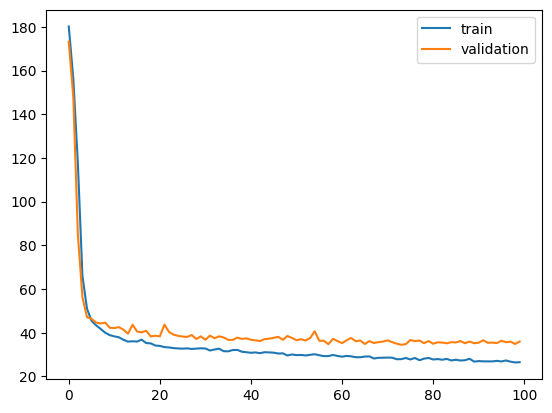

In [33]:
# Plot the chart
plt.plot(axis_x, axis_y, label="train")
plt.plot(axis_val_x, axis_val_y, label="validation")
plt.legend(loc="upper right")
plt.show()  # display

### Test

Following codes are not needed if k-fold validation is enabled.

In [34]:
test_X_array = X_test.iloc[:, :-1].to_numpy()
test_y_array = y_test.to_numpy()

In [35]:
test_X_array = scaler.transform(test_X_array)

In [36]:
test_data = RadiomicDataset(test_X_array, test_y_array)

In [37]:
test_dataloader = DataLoader(test_data, batch_size=batchsize, shuffle=True)

In [38]:
test_size = len(test_dataloader)
num_batches = len(test_dataloader)
test_loss = 0
model.eval()

with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = torch.sqrt(criterion(pred, y)).item()
        # loss = criterion(pred, y).item()
        test_loss += loss
print(f"Test loss: {test_loss/test_size:>8f} \n")

Test loss: 36.419410 



In [39]:
# model.eval()
# with torch.no_grad():
#     for X, y in test_dataloader:
#         X, y = X.to(device), y.to(device)
#         pred = model(X)
#         print(torch.squeeze(pred))
#         print(torch.squeeze(y))
#         break

#### Single Case Testing

In [39]:
import random
ind = random.sample(range(0, len(test_X_array)), 20)
# ind = random.randint(0, len(test_X_array))

In [40]:
for i in ind:
    single_test = torch.tensor(test_X_array[i]).unsqueeze(0).float()
    single_test = single_test.unsqueeze(1)
    single_y_pred = model(single_test.to(device))
    # single_y_pred.item()
    single_y = test_y_array[i]

    print(f'Image:  {X_test.iloc[i,-1]}')
    print(f'Y:      {single_y}')
    print(f'Pred_Y: {single_y_pred.item()}')
    print('-'*50)

Image:  Patient00713_Plane3_4_of_4.png
Y:      208.7171928
Pred_Y: 193.452880859375
--------------------------------------------------
Image:  358_HC.png
Y:      138.7664598
Pred_Y: 93.44202423095703
--------------------------------------------------
Image:  372_HC.png
Y:      140.0331919
Pred_Y: 116.88724517822266
--------------------------------------------------
Image:  133_2HC.png
Y:      98.97632485
Pred_Y: 135.3134002685547
--------------------------------------------------
Image:  Patient01048_Plane3_1_of_1.png
Y:      152.370088
Pred_Y: 185.22068786621094
--------------------------------------------------
Image:  529_HC.png
Y:      140.7641374
Pred_Y: 173.9601287841797
--------------------------------------------------
Image:  Patient01209_Plane3_1_of_7.png
Y:      162.7116183
Pred_Y: 145.47232055664062
--------------------------------------------------
Image:  Patient00896_Plane3_1_of_3.png
Y:      142.5998953
Pred_Y: 140.92779541015625
----------------------------------------